<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_7/7_3_NeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Challenge 


---

Customer churn is a critical challenge for businesses across various industries, as it can significantly impact their revenue and profitability. It refers to the situation when customers discontinue their association with a company or stop using its products or services. The reasons behind churn can be numerous, ranging from poor customer service to the availability of better alternatives in the market.

The challenge: 

Suppose you are an employee of a telecommunications company like Verizon or AT&T, understanding and mitigating customer churn can be crucial for maintaining growth and success in the industry. With an annual valuation of $1200 per customer, losing customers can result in a significant loss of revenue for the company. Therefore, identifying the factors that influence customer churn and implementing strategies to retain customers can help mitigate this risk. 

The company belives that two critical factors that have been identified to influence customer churn are the network speed (5G or 4G LTE) and the phone model. Additionally, the company has observed that customers who opt for paperless billing are less likely to churn. Thus, focusing on providing superior network speed and offering desirable phone models while promoting paperless billing can be effective strategies to retain customers and reduce churn. 

Let's use our analytics skills to test these assertions and at the same time can we build a Decision Tree Classifier to identify likely churners before they churn?



In [10]:
# --------------------------------
import warnings
warnings.filterwarnings('ignore')
# --------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

# -- sklearn stuff -- 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# -- sklearn ML models -- 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline

# Import Data

In [11]:
churn = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_7/Churn_training.csv")
churn.head()

,monthly_minutes,customer_service_calls,streaming_minutes,total_billed,prev_balance,late_payments,ip_address_asn,phone_area_code,customer_reg_date,email_domain,...,currency_code,maling_code,paperless_billing,payment_method,customer_id,billing_address,gender,network_speed,senior_citizen,churn
0,22604.0,2.0,26525.0,285.0,47.0,5.0,16767.0,253.0,2020-04-15,yahoo.com,...,usd,H,No,Mailed Check,1-136-08562-9.1,5592 Gill Pine Suite 387,Female,5G,1.0,0
1,17059.0,2.0,16887.0,201.0,45.0,5.0,53966.0,241.0,2020-04-12,gmail.com,...,eur,V,Yes,Mailed Check,0-384-11264-1.2,5806 Kathleen Mount Suite 186,Male,5G,0.0,0
2,25848.0,2.0,26783.0,264.0,44.0,6.0,19278.0,232.0,2020-02-22,gmail.com,...,cad,R,Yes,Credit Card,0-08-151665-7.3,5037 Allen Square Apt. 727,Male,5G,1.0,0
3,22080.0,3.0,23649.0,274.0,49.0,6.0,16680.0,236.0,2020-08-05,yahoo.com,...,cad,N,No,Mailed Check,0-02-200816-0.4,841 Griffin Route Suite 824,Female,5G,0.0,0
4,23871.0,3.0,7705.0,236.0,61.0,5.0,51308.0,243.0,2019-11-16,gmail.com,...,cad,V,Yes,Electronic Check,0-87476-135-2.5,46185 Mejia Manor Apt. 558,Male,4Glte,1.0,0


# Describe Target


---

So about 5% of customers churn in this sample. 

In [12]:
churn["churn"].value_counts(normalize=False)

0    85926
1     4975
Name: churn, dtype: int64

In [13]:
churn["churn"].value_counts(normalize=True)

0    0.94527
1    0.05473
Name: churn, dtype: float64

# Nulls? 


---

The data is full of nulls so we know we'll need to deal with them when we build our Decision Tree. 



In [14]:
churn.isna().sum(axis=0)

monthly_minutes           20
customer_service_calls    22
streaming_minutes         22
total_billed              34
prev_balance              22
late_payments             20
ip_address_asn            17
phone_area_code           28
customer_reg_date         27
email_domain              28
phone_model               25
billing_city              29
billing_postal            28
billing_state             26
partner                   25
phone_service             25
multiple_lines            24
streaming_plan            28
mobile_hotspot            36
wifi_calling_text         32
online_backup             29
device_protection         29
number_phones             30
contract_code             26
currency_code             29
maling_code               31
paperless_billing         31
payment_method            24
customer_id                0
billing_address           20
gender                    27
network_speed             27
senior_citizen            35
churn                      0
dtype: int64

# Build Nerual Network (MLPClassifier)


---
Here's my basic sugar cookie recipe! 

1. partition data 70/30
2. identify columns and roles as input 
  - target
  - categorical_features
  - numeric_features
3. define pipeline
  - categorical handling:
    - deal with missing values
    - one hot encode categories 
  - numeric handling 
    - deal with missing values
    - scale the data  
  - specify the pipeline
  - specify the model 
  - fit it! 
4. predict and evaluate 



## 1. partition data 70/30


---



In [15]:
train, test = train_test_split(churn,test_size=0.30)

print("train pct: {:2.2%}".format(train.shape[0]/churn.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/churn.shape[0]))

train pct: 70.00%
test  pct: 30.00%


## 2. identify columns and roles as input


---

```python
target = ""
categorical_features = []
numeric_features = []

```

In [16]:
# 0 = not churn, 1 = churn
target = "churn"
print("-- target variable  : {}".format(target))
# -- found durring exploration
categorical_features = ["phone_model","email_domain",'streaming_plan', 'mobile_hotspot',
       'wifi_calling_text', 'online_backup', 'device_protection',
        'contract_code', 'currency_code', 'maling_code',
       'paperless_billing', 'payment_method', 
       'gender', 'network_speed', 'senior_citizen']
print("-- categorical features :")
print(categorical_features)
# -- based on exploration 
numeric_features = ['customer_service_calls', 'ip_address_asn', 'late_payments',
       'monthly_minutes', 'number_phones', 'phone_area_code', 'prev_balance',
       'streaming_minutes', 'total_billed']
print("-- numeric features :")
print(numeric_features)

-- target variable  : churn
-- categorical features :
['phone_model', 'email_domain', 'streaming_plan', 'mobile_hotspot', 'wifi_calling_text', 'online_backup', 'device_protection', 'contract_code', 'currency_code', 'maling_code', 'paperless_billing', 'payment_method', 'gender', 'network_speed', 'senior_citizen']
-- numeric features :
['customer_service_calls', 'ip_address_asn', 'late_payments', 'monthly_minutes', 'number_phones', 'phone_area_code', 'prev_balance', 'streaming_minutes', 'total_billed']


## 3. Define a Pipeline & Fit the model! 


---


### Neural Networks 101
At a high level, neural networks consist of layers of interconnected nodes, or neurons, that process information and make predictions based on that information. These neurons are typically organized into input, hidden, and output layers. The input layer receives data and passes it on to the hidden layers, which perform calculations and make predictions based on the input. Finally, the output layer generates a prediction or decision based on the calculations performed by the hidden layers.

One of the key benefits of neural networks is their ability to learn and improve over time. This is accomplished through a process known as backpropagation, where the network adjusts its weights and biases based on the difference between its predictions and the actual outcomes of the input data. By doing this over many iterations, the neural network can become more accurate in its predictions and can identify patterns that may not be immediately obvious to human analysts.

in our case we are going to create a MLPClassifier key parameters: 

- hidden_layer_sizes:  The parameter takes a tuple where each element of the tuple represents the number of neurons in the corresponding hidden layer. For example, if we set hidden_layer_sizes=(10, 5, 3), the MLP will have 3 hidden layers with 10, 5, and 3 neurons respectively. start with simle architectures hidden_layer_sizes(10,)

- max_iter: max_iter parameter in the MLPClassifier and MLPRegressor classes in scikit-learn is used to specify the maximum number of iterations (epochs) for the solver to converge - more itterations the longer it takes to train! 
> Setting max_iter too low can lead to underfitting, where the model may not learn the underlying patterns in the data. Conversely, setting max_iter too high can lead to overfitting, where the model may memorize the training data and perform poorly on new, unseen data.


Try setting the following and see impact on prediction performance. 

TRY different parameters:

- hidden_layer_sizes=(20,)
- hidden_layer_sizes=(10, 5)

- min_samples_split = 2, 10, 100, and 1000
- ccp_alpha = 0, 0.001,0.0015, 0.0025, 0.005



In [17]:
# Define the column transformer for the categorical variables
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # handling missing values 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # convert categories to 1s and 0s
])

# Define the column transformer for the numeric variables
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),      # replace missing values with median 
    ('scaler', StandardScaler())
])

# Define the full pipeline
preprocessor = ColumnTransformer([
    ('cat', cat_transformer, categorical_features),   # Use one-hot encoding for the first three features
    ('num', num_transformer, numeric_features)  # Use standard scaling for the remaining numeric features
])
# the final pipeline 
nnet_model  = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(10), 
        max_iter=100
     )) # play with the parameters
])



# Fit the pipeline to the training data
nnet_model.fit(train[numeric_features + categorical_features], train[target])

# Predict on the train and test data sets
y_pred_train = nnet_model.predict(train[numeric_features + categorical_features])
y_pred_test = nnet_model.predict(test[numeric_features + categorical_features])


## 5.  Predict 


---

The goal of classification tasks is to predict a categorical output variable based on a set of input features. In our case the "target" can take a 0 = not_churn and a 1 = churn. When making predictions we have two functions we need to be aware of. 

- `.predict(X)` : takes a set of input features as input and returns the predicted **class** for each instance. It does the by calculating the predicted probabilty for each class and assigns the "positive" class if the predicted probably of the postitive class is >= 0.5

- `.predict_proba(X)` : takes in the set of input features as input and returns the **predicted probabilites** for each class.  Typically, you will operate a ML model based on the predicted probabilites not the predicted class. 



In [21]:
# train predictions 
train["predicted_class"] = nnet_model.predict(train[numeric_features + categorical_features])
train["predicted_prob0"], train["predicted_prob1"] = nnet_model.predict_proba(train[numeric_features + categorical_features]).T
train[["churn","predicted_class","predicted_prob0","predicted_prob1"]]\
.query('predicted_prob1 > 0.25 and predicted_prob1 < 0.75').head(10)

,churn,predicted_class,predicted_prob0,predicted_prob1
60797,1,1,0.257719,0.742281
78570,1,0,0.508628,0.491372
18931,1,1,0.356154,0.643846
69315,1,1,0.498343,0.501657
29085,1,1,0.328701,0.671299
74929,1,1,0.423391,0.576609
34643,0,0,0.691030,0.308970
16650,1,0,0.674944,0.325056
27122,0,1,0.359401,0.640599
69860,1,1,0.368615,0.631385


In [22]:
test["predicted_class"] = nnet_model.predict(test[numeric_features + categorical_features])
test["predicted_prob0"], test["predicted_prob1"] = nnet_model.predict_proba(test[numeric_features + categorical_features]).T
test[["churn","predicted_class","predicted_prob0","predicted_prob1"]].head(10)

,churn,predicted_class,predicted_prob0,predicted_prob1
64025,0,0,0.994121,0.005879
70651,0,0,0.998522,0.001478
35840,0,0,0.999689,0.000311
59247,0,0,0.994262,0.005738
41685,0,0,0.988118,0.011882
26622,0,0,0.997528,0.002472
66889,0,0,0.920820,0.079180
82620,0,0,0.987015,0.012985
49396,0,0,0.999801,0.000199
90658,0,0,0.983431,0.016569


## Confusion Matrix 


---




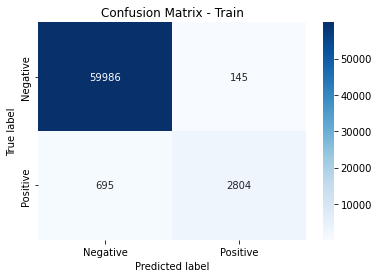

In [23]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix
cm = confusion_matrix(train[target], train["predicted_class"])

# Define the labels for the confusion matrix
labels = ["Negative", "Positive"]

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels);
plt.title("Confusion Matrix - Train")
# Update the x and y axis labels
plt.xlabel("Predicted label")
plt.ylabel("True label");


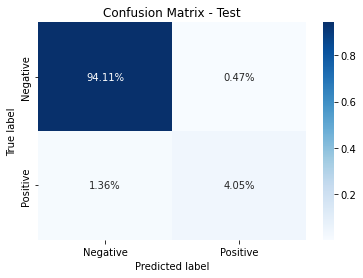

In [24]:
cm = confusion_matrix(test[target], test["predicted_class"])

# Define the labels for the confusion matrix
labels = ["Negative", "Positive"]
total = float(cm.sum())
# Create a heatmap of the confusion matrix
sns.heatmap(cm/total, annot=True, cmap="Blues", fmt='.2%', xticklabels=labels, yticklabels=labels);
plt.title("Confusion Matrix - Test")
# Update the x and y axis labels
plt.xlabel("Predicted label")
plt.ylabel("True label");

## Look at the predicted probably distribution! 


---

In a classification model, the predicted probability distribution refers to the estimated probabilities of each possible class label - in our case churn / not churn,  indicating the likelihood that the input belongs to that particular class.

For example, in a binary classification problem where we are predicting whether a customer will churn or not, the predicted probability distribution could be [0.2, 0.8], indicating that the model estimates a 20% chance that the customer will churn and an 80% chance that they will not.

**The predicted probability distribution is often used to make decisions about the predicted class label. For instance, we may choose to predict the class label with the highest probability, or we may set a threshold probability and predict the positive class if the probability exceeds the threshold, and the negative class otherwise**

We can also use the predicted probability to assess the confidence of a model's prediction. For instance, if the model assigns a high probability to the predicted class label, we can be more confident that the prediction is correct compared to when the probability is close to 0.5, indicating that the model is uncertain about the prediction.



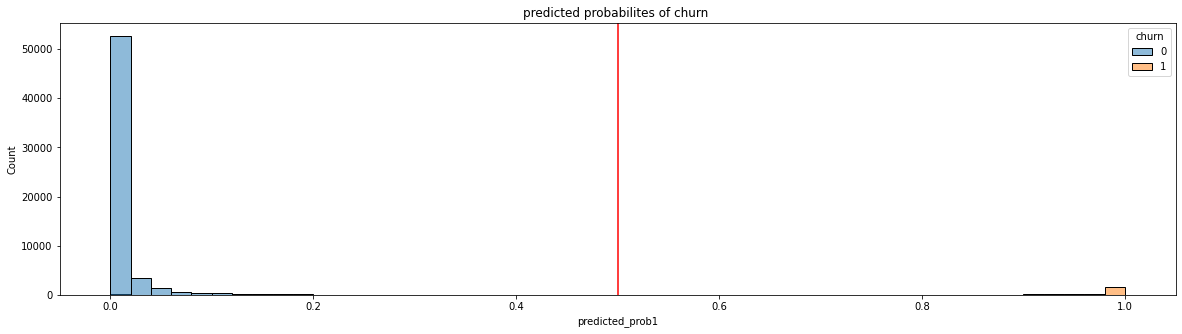

In [27]:
#- plot
plt.figure(figsize=(20, 5))
sns.histplot(train, bins=50, x="predicted_prob1",hue="churn")
plt.axvline(x=0.5, color="red")
plt.title("predicted probabilites of churn ")
plt.show()

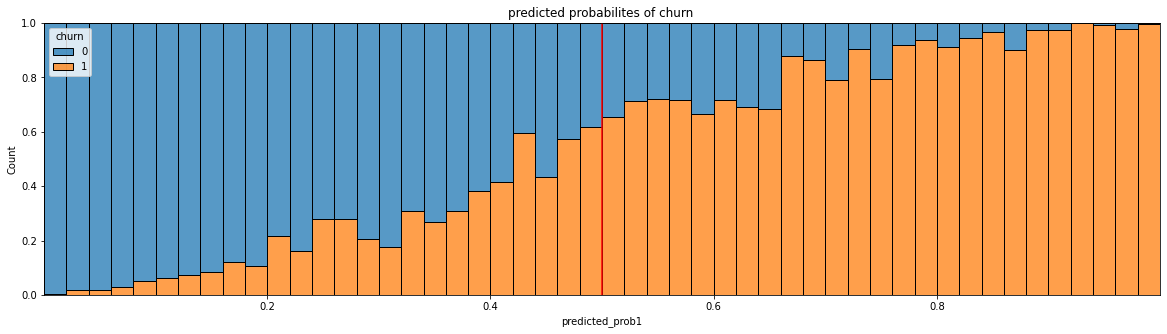

In [28]:
#- plot
plt.figure(figsize=(20, 5))
sns.histplot(train, bins=50, x="predicted_prob1",  multiple="fill", hue="churn")
plt.axvline(x=0.5, color="red")
plt.title("predicted probabilites of churn ")
plt.show()

## Evaluate 


---

Calculate the following 
- accuracy
- recall
- precision

In [29]:
data_sets = {"train":train,
             "test": test}

for i in data_sets.keys():
  print("-- partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["predicted_class"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["predicted_class"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["predicted_class"] )
  print("Precision  : {:2.2%}".format(precision))


-- partition: train --
Accuracy   : 98.68%
Recall     : 80.14%
Precision  : 95.08%
-- partition: test --
Accuracy   : 98.16%
Recall     : 74.80%
Precision  : 89.54%


## What happens if... 


---

Your boss says great! BUT can you improve the RECALL of the model by changing the predicted probability down to 0.25 and in another scenario they want you to crank the predicted probably threshold up to 0.75. 


Effectively 
1. scenario 1: find more churners at expense of higher false positives 
> IF predicted_prob1 >= 0.25 then predicted_churn
2. scenario 2: find fewer churners at expense of lower RECALL
> IF predicted_prob1 >= 0.75 then predicted_churn




lets create two new class assignments 
```python

# Update the predicted_prob1 column based on a threshold of 0.25
test["scenario_1"] = np.where(test["predicted_prob1"] >= 0.25, 0, 1)

test["scenario_2"] = np.where(test["predicted_prob1"] >= 0.75, 0, 1)
```



In [30]:
train["scenario_1"] = np.where(train["predicted_prob1"] >= 0.25, 1, 0)
train["scenario_2"] = np.where(train["predicted_prob1"] >= 0.75, 1, 0)

test["scenario_1"] = np.where(test["predicted_prob1"] >= 0.25, 1, 0)
test["scenario_2"] = np.where(test["predicted_prob1"] >= 0.75, 1, 0)

data_sets = {"train":train,
             "test": test}

for i in data_sets.keys():
  print("-- scenario 1 partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["scenario_1"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["scenario_1"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["scenario_1"] )
  print("Precision  : {:2.2%}".format(precision))

print("\n")

for i in data_sets.keys():
  print("-- scenario 2 partition: {} --".format(i))
  accuracy = accuracy_score(data_sets[i][target], data_sets[i]["scenario_2"])
  print("Accuracy   : {:2.2%}".format(accuracy))
  recall = recall_score(data_sets[i][target].values,data_sets[i]["scenario_2"] )
  print("Recall     : {:2.2%}".format(recall))
  precision = precision_score(data_sets[i][target].values,data_sets[i]["scenario_2"] )
  print("Precision  : {:2.2%}".format(precision))

-- scenario 1 partition: train --
Accuracy   : 98.42%
Recall     : 85.94%
Precision  : 85.43%
-- scenario 1 partition: test --
Accuracy   : 97.92%
Recall     : 81.98%
Precision  : 80.08%


-- scenario 2 partition: train --
Accuracy   : 98.30%
Recall     : 70.13%
Precision  : 98.44%
-- scenario 2 partition: test --
Accuracy   : 97.96%
Recall     : 65.99%
Precision  : 94.66%
